In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder


In [18]:
df = pd.read_csv("data/processed-data.csv")

# perform one-hot encoding for categorical columns
df = pd.get_dummies(df, columns = ['ph', 'rainfall'])

# split the dataframe into features (x) and labels (y)
x = df.drop(columns = ['label'])
y = df['label']

In [19]:
# Split dataset into 90% seen (train+test) and 10% unseen
x_seen, x_unseen, y_seen, y_unseen = train_test_split(x, y, test_size=0.10, random_state=42)

# # Split the 90% seen data into 80% training and 20% testing
# x_train, x_test, y_train, y_test = train_test_split(x_seen, y_seen, test_size=0.20, random_state=42)

# Train a Decision Tree Classifier
dtc_model = DecisionTreeClassifier()

In [21]:
# # instantiate a 10-fold cross-validation
# kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
# # perform cross-validation predictions
# y_pred_cv = cross_val_predict(dtc_model, x_train, y_train, cv = kf)
#
# # evaluation metrics
# conf_matrix = confusion_matrix(y_train, y_pred_cv)
# accuracy = accuracy_score(y_train, y_pred_cv)
# precision = precision_score(y_train, y_pred_cv, average = 'weighted')
# recall = recall_score(y_train, y_pred_cv, average = 'weighted')
# y_proba_cv = cross_val_predict(dtc_model, x_train, y_train, cv = kf, method = 'predict_proba')
# roc_auc = roc_auc_score(y_train, y_proba_cv, multi_class = 'ovr')
#
#
# # results for the cross validation
# print('\nCross Validation Evaluation Results:')
# print('Confusion Matrix: \n', conf_matrix)
# print(f'Accuracy: {accuracy:.4f}')
# print(f'Precision: {precision:.4f}')
# print(f'Recall: {recall:.4f}')
# print(f'ROC AUC: {roc_auc:.4f}')


Cross Validation Evaluation Results:
Confusion Matrix: 
 [[74  0  0  0  0  0  2  0  0  0]
 [ 0 69  0  0  0  0  0  0  0  0]
 [ 0  0 76  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0 12  0]
 [ 0  0  0  0 75  0  0  0  0  0]
 [ 0  0  0  0  0 75  0  0  0  0]
 [ 0  1  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 74  0  0]
 [ 0  0  0 17  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0  0 68]]
Accuracy: 0.9556
Precision: 0.9559
Recall: 0.9556
ROC AUC: 0.9726


Decision Tree Rules:
 |--- Potassium Content <= 0.10
|   |--- Nitrogen Content <= 0.36
|   |   |--- humidity <= 0.32
|   |   |   |--- class: kidneybeans
|   |   |--- humidity >  0.32
|   |   |   |--- class: lentil
|   |--- Nitrogen Content >  0.36
|   |   |--- humidity <= 0.74
|   |   |   |--- Potassium Content <= 0.05
|   |   |   |   |--- class: maize
|   |   |   |--- Potassium Content >  0.05
|   |   |   |   |--- Phosphorous Content <= 0.28
|   |   |   |   |   |--- class: coffee
|   |   |   |   |--- Phosphorous Content >  0.28
|   |   |   |   |   |--- class: maize
|   |   |--- humidity >  0.74
|   |   |   |--- class: cotton
|--- Potassium Content >  0.10
|   |--- Phosphorous Content <= 0.20
|   |   |--- temperature <= 0.55
|   |   |   |--- Potassium Content <= 0.13
|   |   |   |   |--- class: coffee
|   |   |   |--- Potassium Content >  0.13
|   |   |   |   |--- class: watermelon
|   |   |--- temperature >  0.55
|   |   |   |--- class: muskmelon
|   |--- Phosphorous Content >  0.20
|

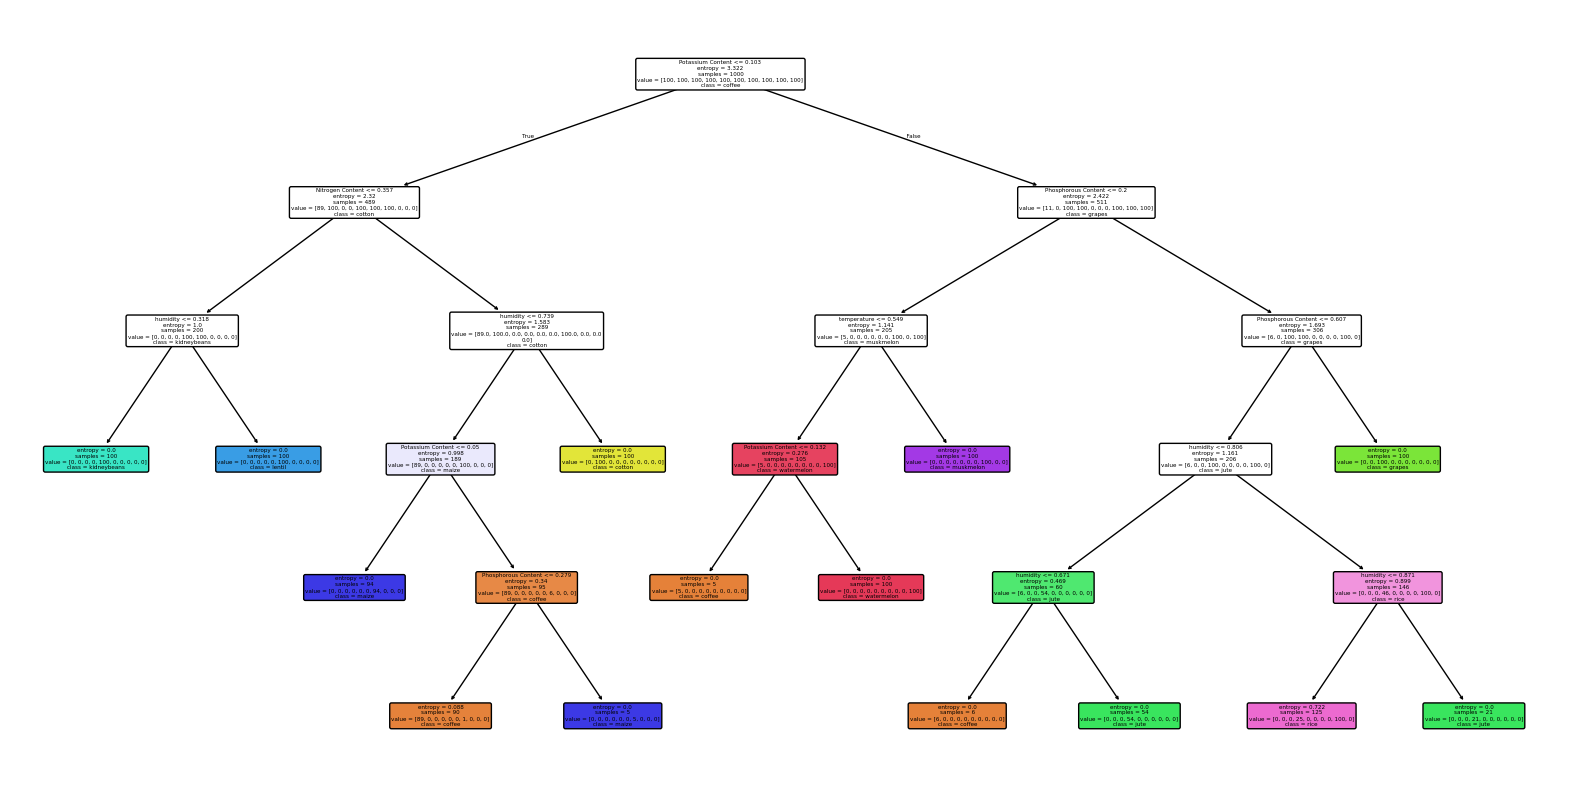

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from collections import defaultdict

# Load dataset
df = pd.read_csv("data/processed-data.csv")

# Encode categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['ph', 'rainfall'])

# Split features and target
X = df.drop(columns=['label'])
y = df['label']

# Train a decision tree model
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
# dt = DecisionTreeClassifier()
dt.fit(X, y)

# Show decision rules in tree format
rules = export_text(dt, feature_names=X.columns.tolist())
print("Decision Tree Rules:\n", rules)

# Extract rules in paragraph form
feature_names = X.columns.tolist()
def extract_rules(tree, feature_names, class_names):
    rules_dict = defaultdict(list)

    def traverse(node, conditions=[]):
        if tree.children_left[node] == -1 and tree.children_right[node] == -1:
            label = class_names[np.argmax(tree.value[node])]
            rules_dict[label].append("; ".join(conditions))
        else:
            feature = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            left_conditions = conditions + [f"{feature} <= {threshold:.2f}"]
            right_conditions = conditions + [f"{feature} > {threshold:.2f}"]
            traverse(tree.children_left[node], left_conditions)
            traverse(tree.children_right[node], right_conditions)

    traverse(0)
    return rules_dict

rules_dict = extract_rules(dt.tree_, feature_names, dt.classes_)

print("\nRules in Paragraph Form:")
for label, conditions in rules_dict.items():
    print(f"\nRules for {label}:")
    for idx, rule in enumerate(conditions, 1):
        print(f"{idx}. {rule}")

# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=dt.classes_, filled=True, rounded=True)
plt.savefig("decision_tree.png")  # Save as PNG
plt.show()

